In [1]:
import pandas as pd

hit_file = "../ml/processed_events_small/normalized_features_z_3.parquet"
train_data = pd.read_parquet(hit_file)

In [2]:
# ordered numbers of unique planes

arr = train_data['plane'].unique()

arr.sort()
arr

array([ 0.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [3]:
train_data['Z_transformed'].max

<bound method Series.max of 0         0.080174
1        -0.120803
2        -1.527876
3         1.285779
4        -1.929800
            ...   
900874    0.883097
900875   -1.126801
900876    0.078852
900877   -0.723425
900878    1.083039
Name: Z_transformed, Length: 900879, dtype: float64>

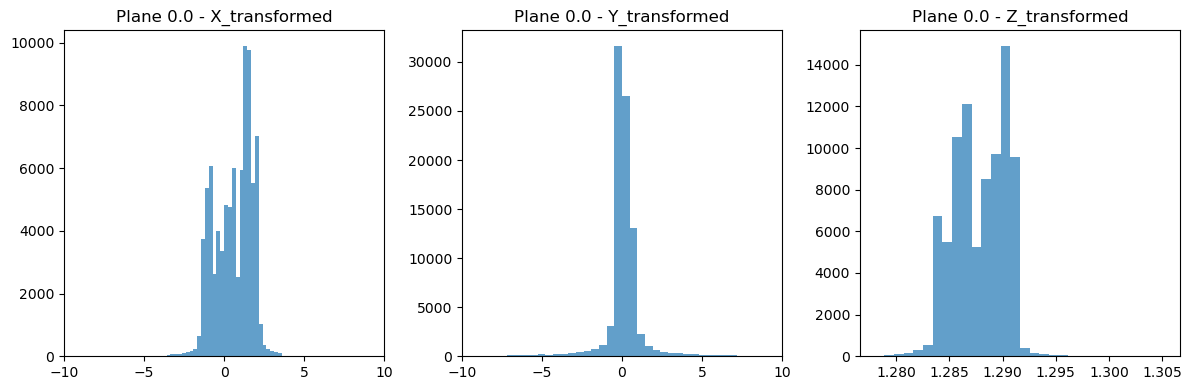

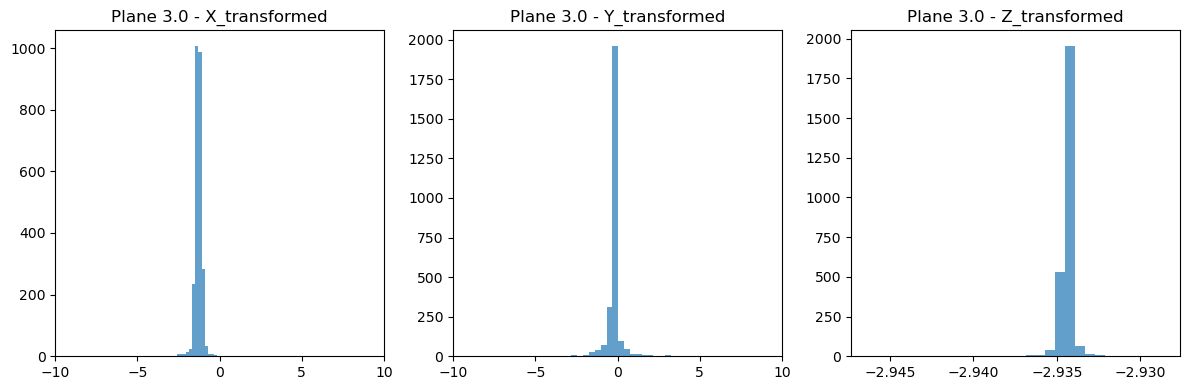

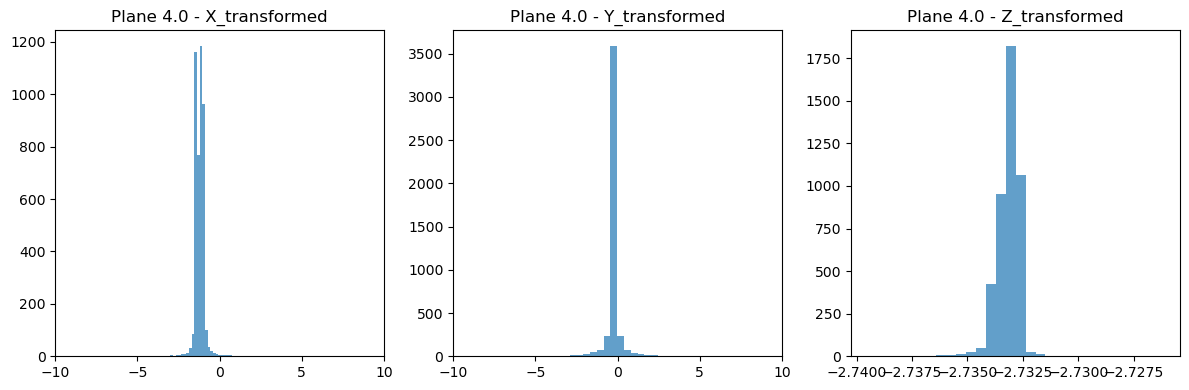

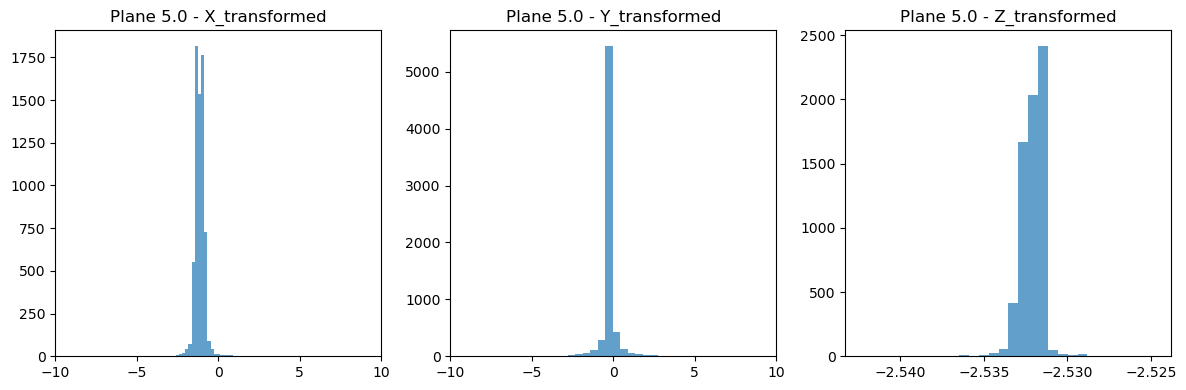

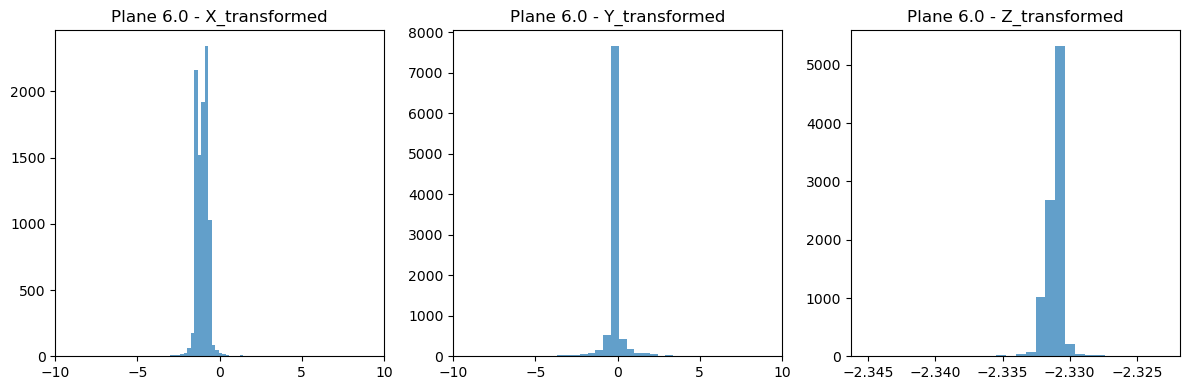

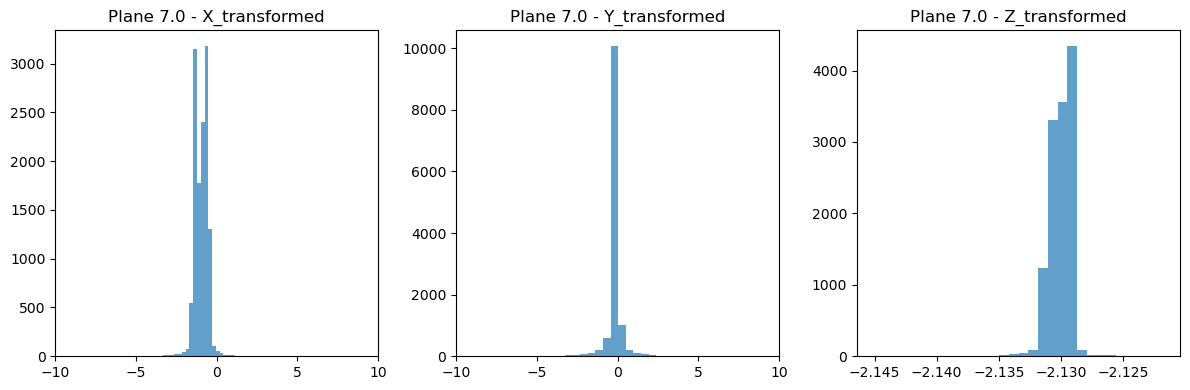

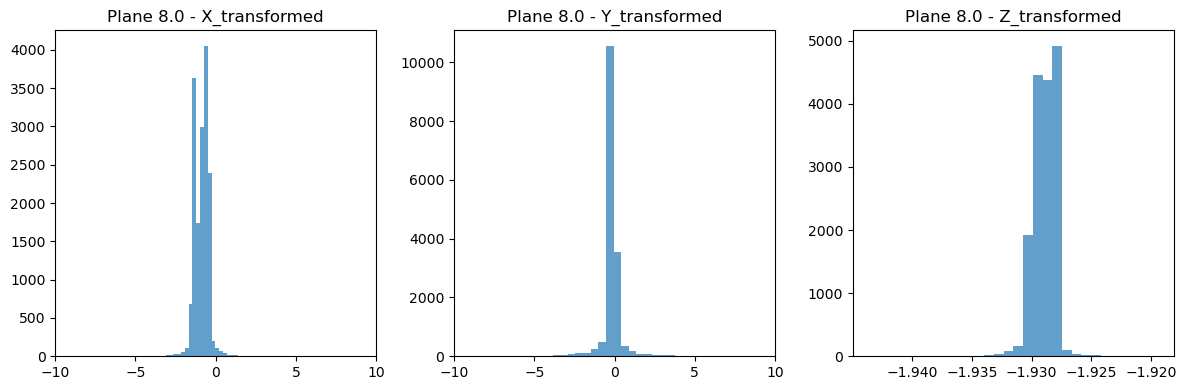

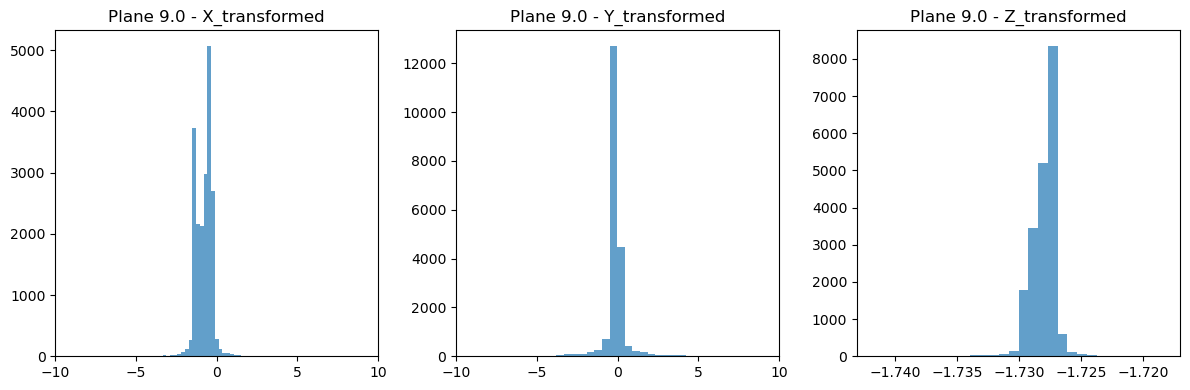

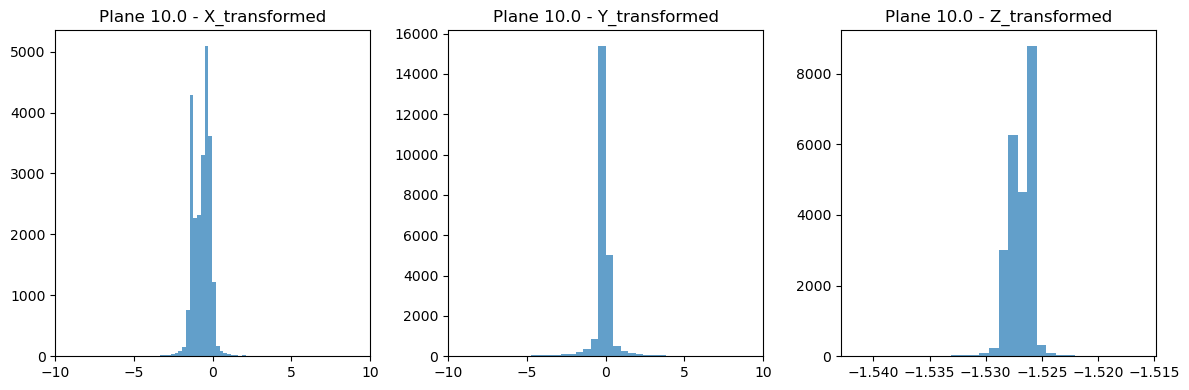

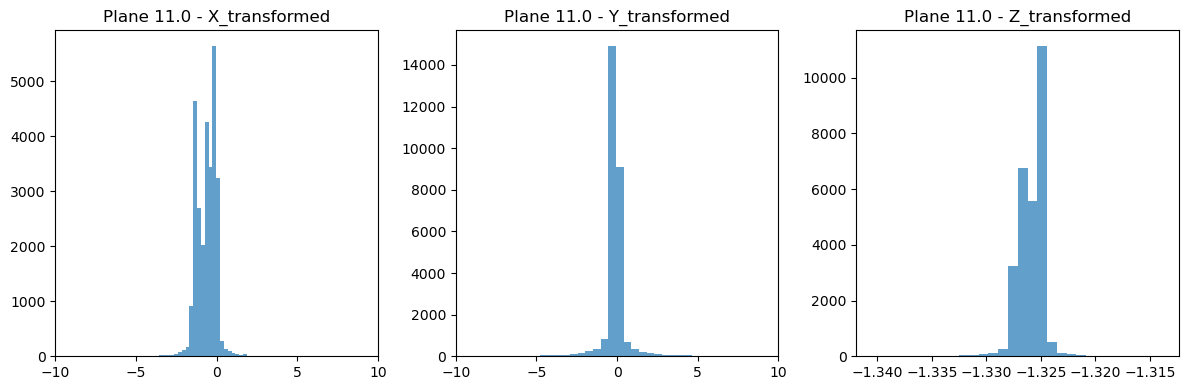

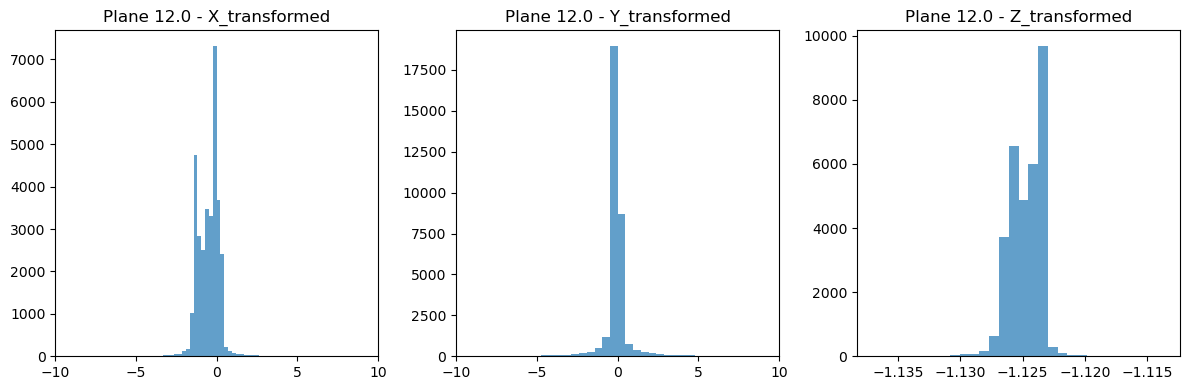

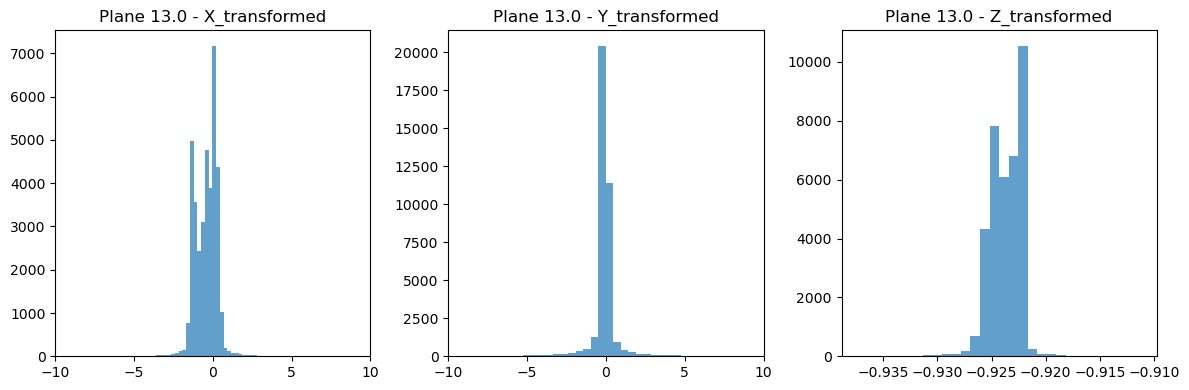

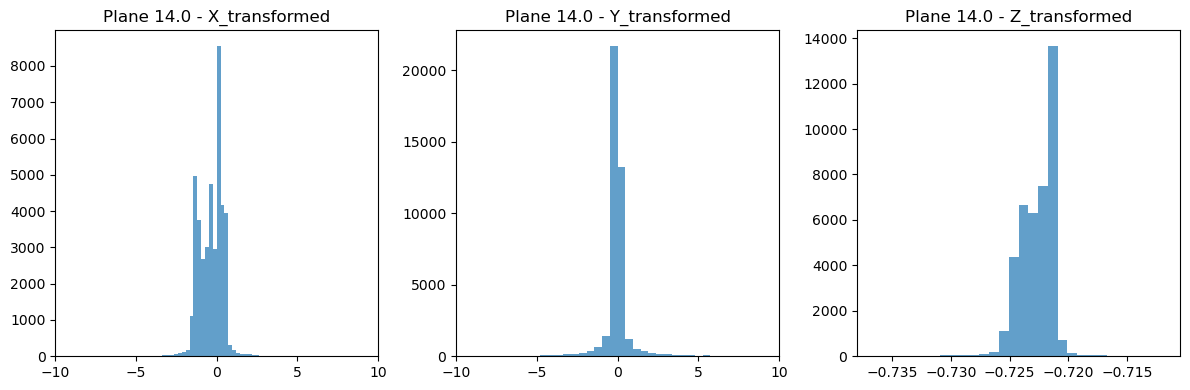

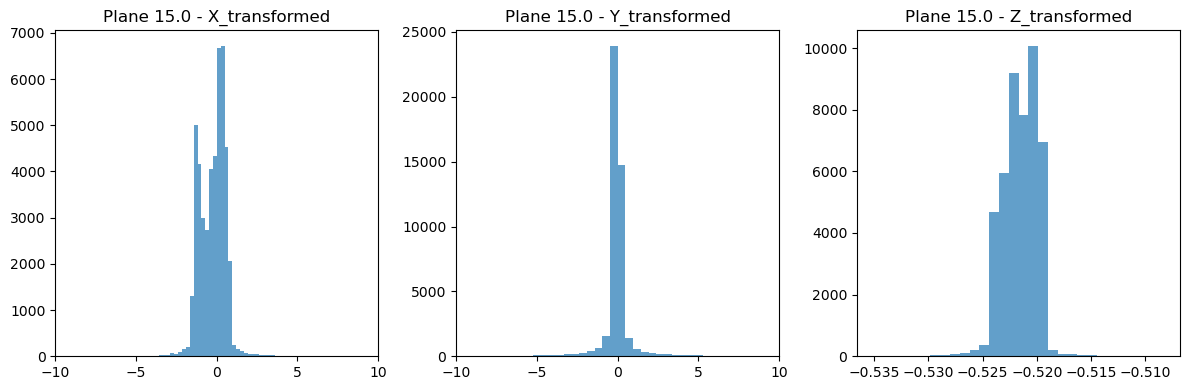

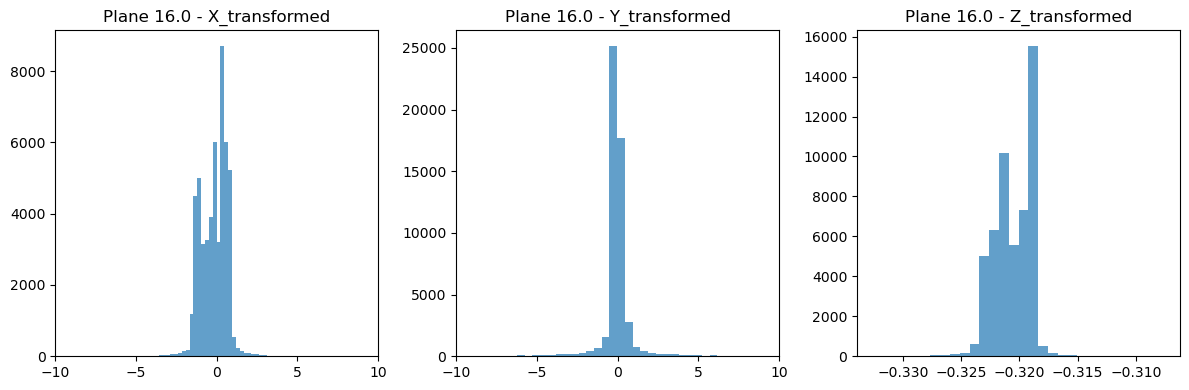

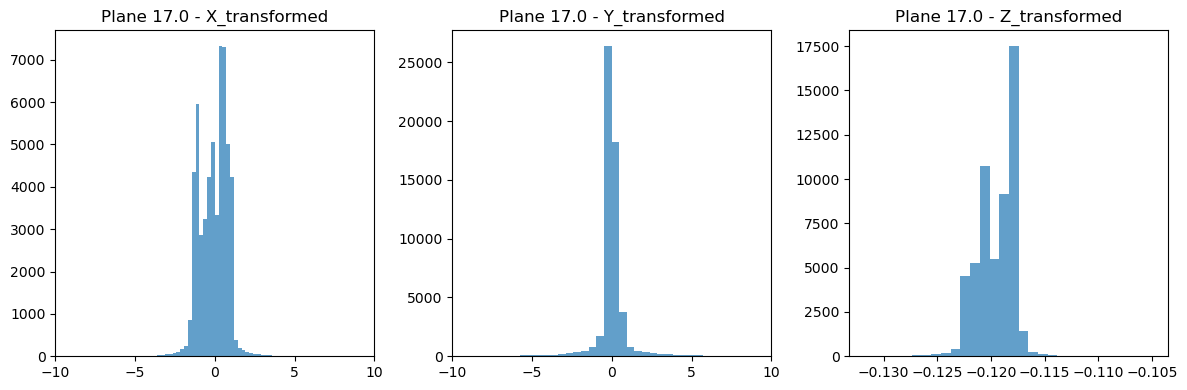

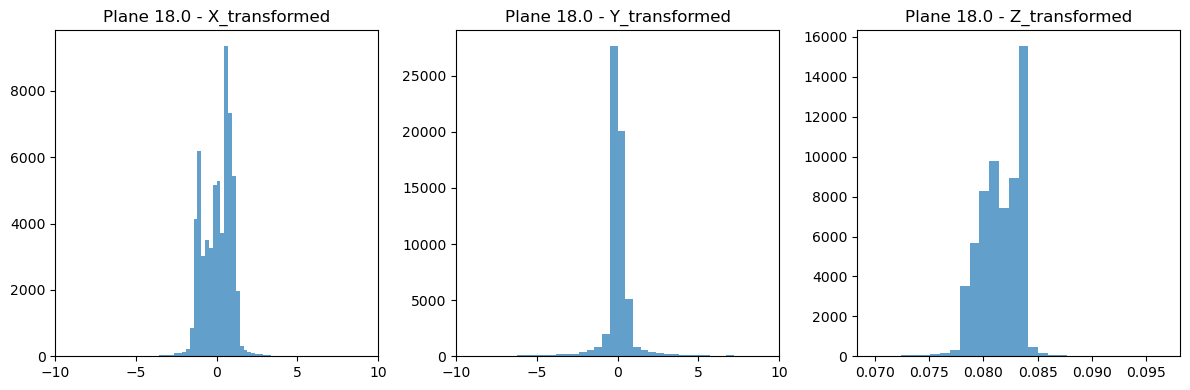

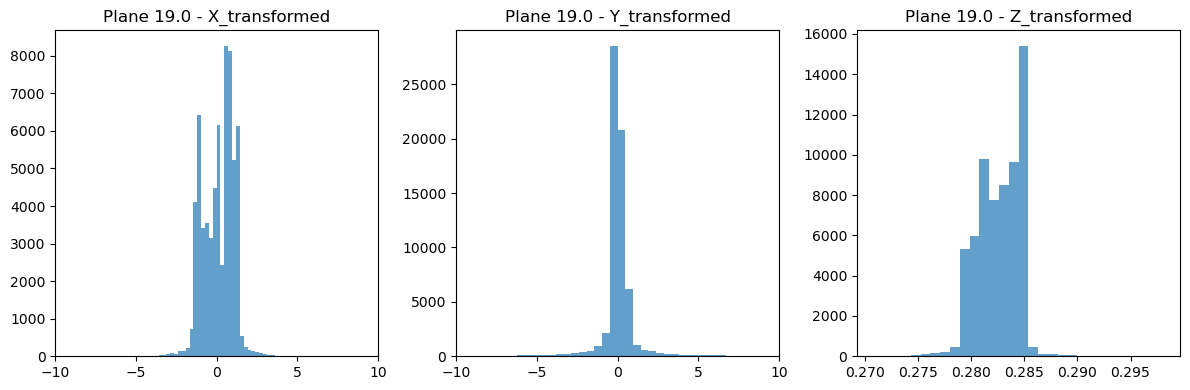

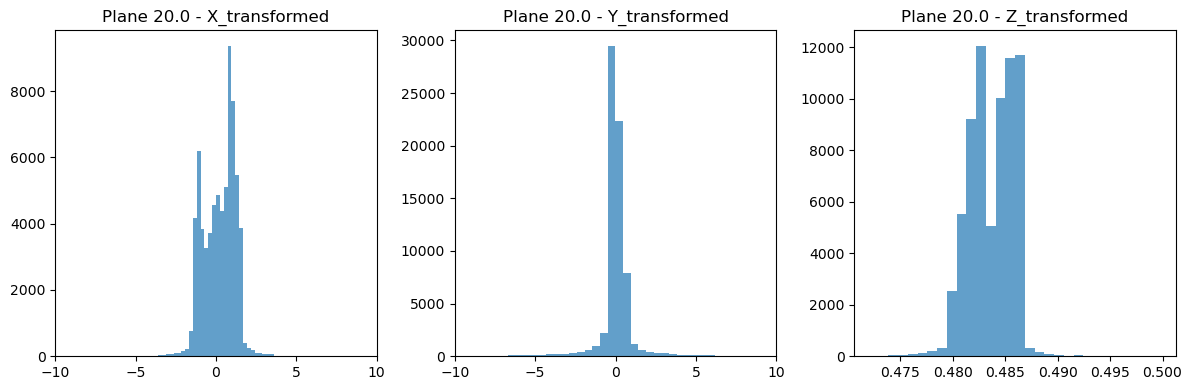

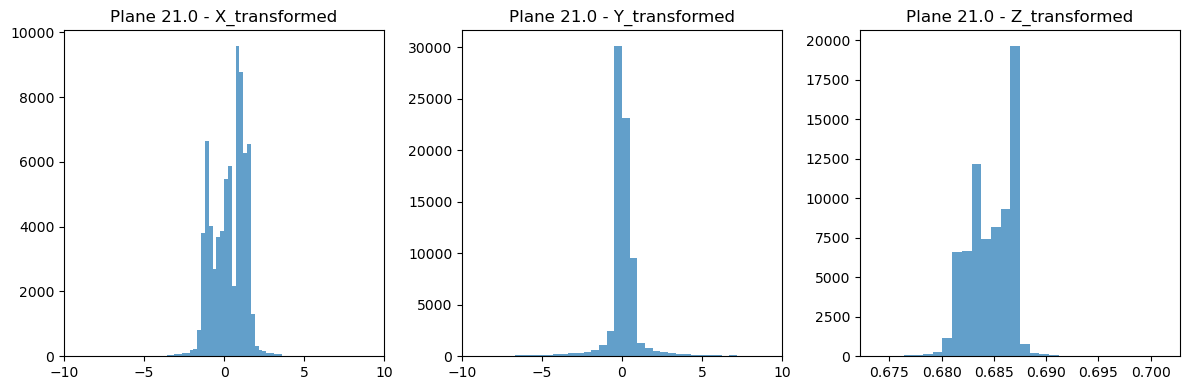

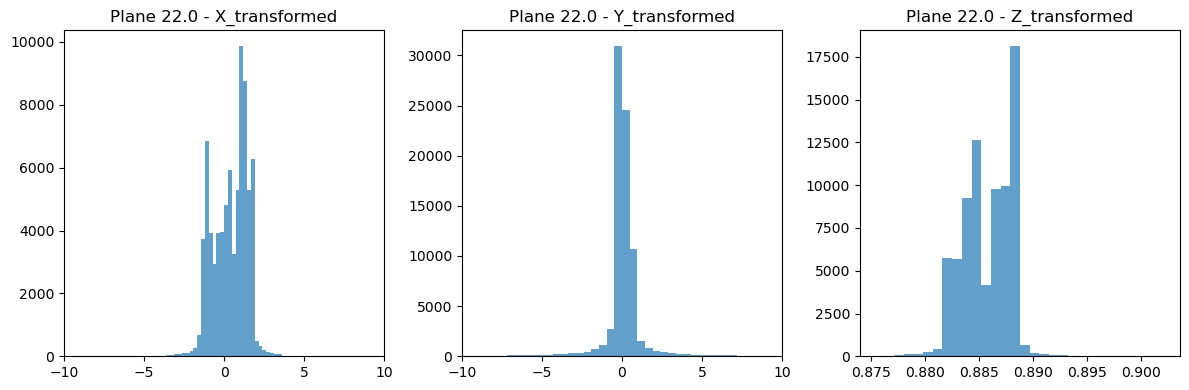

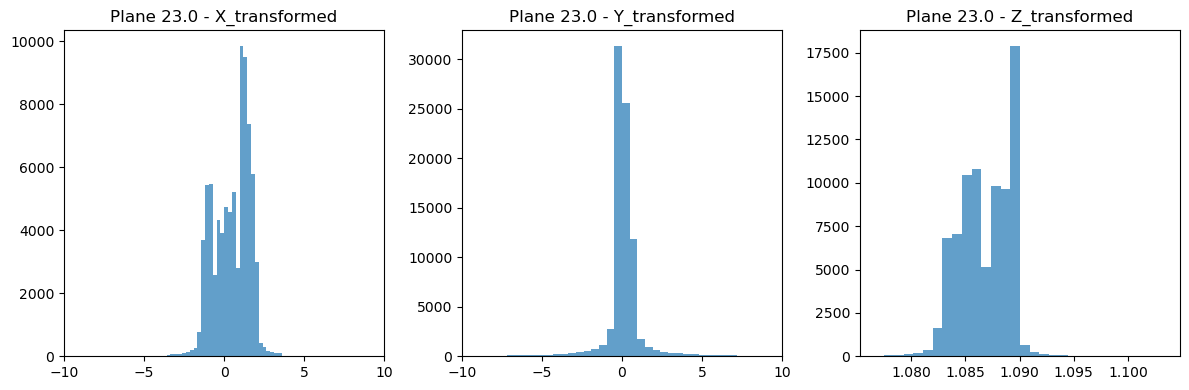

In [4]:
# group data for each plane
# measure variation for each of the x, y z coordinates for each plane
# average std deviation and mean
# plot histogram of each dimension for each plane

import matplotlib.pyplot as plt
df = train_data.copy()
arr = df['plane'].unique()
arr.sort()

for plane in arr:
    df_plane = df[df['plane'] == plane]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(df_plane['X_transformed'], bins=30, alpha=0.7, label='X_transformed')
    plt.title(f'Plane {plane} - X_transformed')
    plt.xlim(-10, 10)
    plt.subplot(1, 3, 2)
    plt.hist(df_plane['Y_transformed'], bins=30, alpha=0.7, label='Y_transformed')
    plt.title(f'Plane {plane} - Y_transformed')
    plt.xlim(-10, 10)
    plt.subplot(1, 3, 3)
    plt.hist(df_plane['Z_transformed'], bins=30, alpha=0.7, label='Z_transformed')
    plt.title(f'Plane {plane} - Z_transformed')
    # plt.xlim(-10, 10)
    plt.tight_layout()
    plt.show()
    
# df_grouped = df.groupby('plane').agg({
#     'X_transformed': ['mean', 'min', 'max'],
#     'Y_transformed': ['mean', 'min', 'max'],
#     'Z_transformed': ['mean', 'min', 'max']
# }).reset_index()

# df_grouped

In [5]:
import sklearn as sk
from sklearn.model_selection import train_test_split

input_columns = [
            "primary_kinetic_energy",
            "sin_azimuth", "cos_azimuth", "sin_zenith", "cos_zenith"
        ]
output_columns = [
            "kinetic_energy", 
            # "distance",
            "X_transformed", "Y_transformed", "Z_transformed",
        ]
batch_identifier = "event_id"

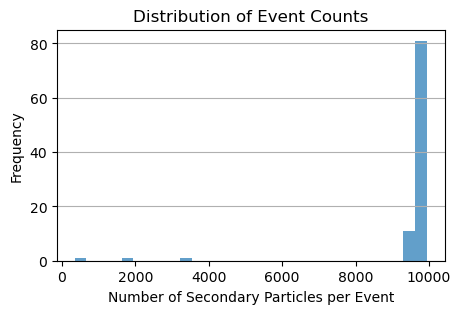

In [6]:
import matplotlib.pyplot as plt

# count number of rows per event and plot distribution
event_counts = train_data[batch_identifier].value_counts().sort_index()
plt.figure(figsize=(5, 3))
plt.hist(event_counts, bins=30, alpha=0.7)
plt.title("Distribution of Event Counts")
plt.xlabel("Number of Secondary Particles per Event")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [7]:
# print average variation in input columns for each event
for col in input_columns:
    event_variation = train_data.groupby(batch_identifier)[col].std()
    print(f"Average variation in {col} per event:\n", event_variation.mean())

Average variation in primary_kinetic_energy per event:
 0.0
Average variation in sin_azimuth per event:
 0.0
Average variation in cos_azimuth per event:
 0.0
Average variation in sin_zenith per event:
 0.0
Average variation in cos_zenith per event:
 0.0


In [8]:
# select only plane 23
event_stats = train_data[train_data['plane'] == 23].reset_index(drop=True)

# for each event keep the input features and calcuate mean and std of the outptu features
# save mean and std in separate columns using _ suffixes
event_stats = event_stats.groupby(batch_identifier).agg(
    {
        **{col : 'first' for col in input_columns},
        **{col: ['mean', 'std'] for col in output_columns}
    }
).reset_index()

event_stats.columns = [f"{col}_{stat}" if stat in ['mean', 'std'] else col for col, stat in event_stats.columns]

In [9]:
# update output feature names
output_columns = [f"{col}_mean" for col in output_columns] + [f"{col}_std" for col in output_columns]

In [10]:
event_stats.head()

,event_id,primary_kinetic_energy,sin_azimuth,cos_azimuth,sin_zenith,cos_zenith,kinetic_energy_mean,kinetic_energy_std,X_transformed_mean,X_transformed_std,Y_transformed_mean,Y_transformed_std,Z_transformed_mean,Z_transformed_std
0,33619162.0,-1.490952,0.105454,0.994424,0.046285,0.998928,-0.282641,0.710958,1.434708,0.483995,0.772813,1.191852,1.084787,0.001614
1,33619823.0,-0.579293,0.085189,0.996365,0.041124,0.999154,-0.313948,0.687525,1.127936,0.352170,0.427073,0.989093,1.085770,0.001043
2,33619872.0,0.516080,0.021693,0.999765,0.001436,0.999999,0.045225,0.965363,-1.402480,0.219676,-0.307636,0.613163,1.089667,0.000023
3,33619891.0,-0.467041,0.062685,0.998033,0.007695,0.999970,-0.286517,0.720049,-0.984278,0.440361,-0.150676,1.097913,1.089523,0.000244
4,33619916.0,-0.611274,0.075489,0.997147,0.044536,0.999008,-0.205267,0.740301,1.342423,0.381836,0.434033,1.284820,1.085115,0.001225


In [11]:
print(f"Event stats columns: {event_stats.columns}")
print(f"Input columns: {input_columns}")
print(f"Output columns: {output_columns}")

Event stats columns: Index(['event_id', 'primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth',
       'sin_zenith', 'cos_zenith', 'kinetic_energy_mean', 'kinetic_energy_std',
       'X_transformed_mean', 'X_transformed_std', 'Y_transformed_mean',
       'Y_transformed_std', 'Z_transformed_mean', 'Z_transformed_std'],
      dtype='object')
Input columns: ['primary_kinetic_energy', 'sin_azimuth', 'cos_azimuth', 'sin_zenith', 'cos_zenith']
Output columns: ['kinetic_energy_mean', 'X_transformed_mean', 'Y_transformed_mean', 'Z_transformed_mean', 'kinetic_energy_std', 'X_transformed_std', 'Y_transformed_std', 'Z_transformed_std']


In [12]:
# split inputs and outputs 
X = event_stats[input_columns]
y = event_stats[output_columns]

# split into training and validation sets using sklearn
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1234)

print(f"Training set size: {X_train.shape[0]} events")
print(f"Validation set size: {X_val.shape[0]} events")

Training set size: 76 events
Validation set size: 19 events


In [13]:
# list number of features
print(f"Number of input features: {X_train.shape[1]}")
print(f"Number of output features: {y_train.shape[1]}")

Number of input features: 5
Number of output features: 8


In [14]:
# train a simple FFN model based on torch
import torch.nn as nn
class SimpleFFN(nn.Module):
    def __init__(self, input_size=5, output_size=10, hidden_dim=10):
        super(SimpleFFN, self).__init__()
        
        self.hit_encoder = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.event_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size),
        )
        
        
    def forward(self, x):
        x = self.hit_encoder(x)
        x = self.event_head(x)
        return x

In [15]:
# train and test NN model using adam optimizer and MSE loss

import torch
import torch.optim as optim
model = SimpleFFN(input_size=X_train.shape[1], output_size=y_train.shape[1], hidden_dim=10)
# use relative error as loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [16]:
# start training loop
num_epochs = 300000
epochs = []
val_losses = []

inputs = torch.tensor(X_train.values, dtype=torch.float32)
targets = torch.tensor(y_train.values, dtype=torch.float32)
val_inputs = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y_val.values, dtype=torch.float32)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()    
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    loss.backward()
    optimizer.step()
    
    if (epoch) % 100 == 0:
        model.eval()
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_targets)
        
        epochs.append(epoch)
        val_losses.append(val_loss.item())
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch [1/300000], Loss: 0.7067, Val Loss: 0.7256
Epoch [101/300000], Loss: 0.6706, Val Loss: 0.6927
Epoch [201/300000], Loss: 0.6347, Val Loss: 0.6604
Epoch [301/300000], Loss: 0.5981, Val Loss: 0.6280
Epoch [401/300000], Loss: 0.5482, Val Loss: 0.5854
Epoch [501/300000], Loss: 0.4922, Val Loss: 0.5367
Epoch [601/300000], Loss: 0.4348, Val Loss: 0.4860
Epoch [701/300000], Loss: 0.3781, Val Loss: 0.4374
Epoch [801/300000], Loss: 0.3219, Val Loss: 0.3875
Epoch [901/300000], Loss: 0.2717, Val Loss: 0.3385
Epoch [1001/300000], Loss: 0.2321, Val Loss: 0.2952
Epoch [1101/300000], Loss: 0.2044, Val Loss: 0.2616
Epoch [1201/300000], Loss: 0.1863, Val Loss: 0.2379
Epoch [1301/300000], Loss: 0.1752, Val Loss: 0.2219
Epoch [1401/300000], Loss: 0.1686, Val Loss: 0.2117
Epoch [1501/300000], Loss: 0.1648, Val Loss: 0.2054
Epoch [1601/300000], Loss: 0.1627, Val Loss: 0.2016
Epoch [1701/300000], Loss: 0.1616, Val Loss: 0.1993
Epoch [1801/300000], Loss: 0.1610, Val Loss: 0.1981
Epoch [1901/300000], Los

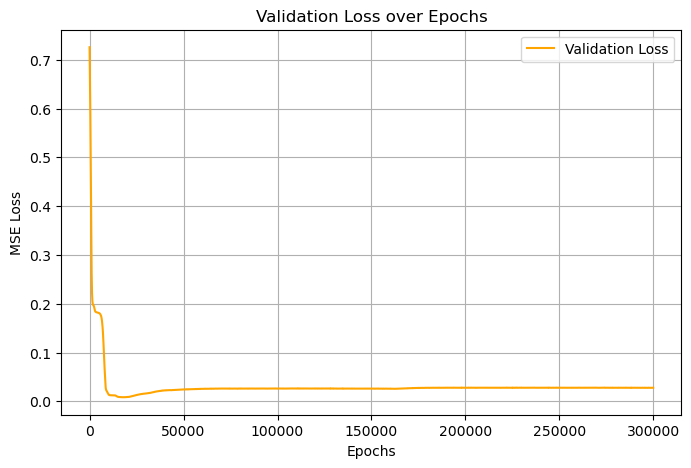

In [17]:
# plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

In [18]:
# test the model on validation set
model.eval()
val_inputs = torch.tensor(X_val.values, dtype=torch.float32)
val_targets = torch.tensor(y_val.values, dtype=torch.float32)
val_outputs = model(val_inputs)
val_loss = criterion(val_outputs, val_targets)
print(f"Final Validation Loss: {val_loss.item():.4f}")

Final Validation Loss: 0.0276


In [19]:
# mean output values in data
mean_values = event_stats[output_columns].mean()
print("Mean output values in data:")
print(mean_values)

Mean output values in data:
kinetic_energy_mean   -0.038131
X_transformed_mean     0.459369
Y_transformed_mean     0.086596
Z_transformed_mean     1.086916
kinetic_energy_std     0.890318
X_transformed_std      0.410481
Y_transformed_std      1.034682
Z_transformed_std      0.000884
dtype: float64


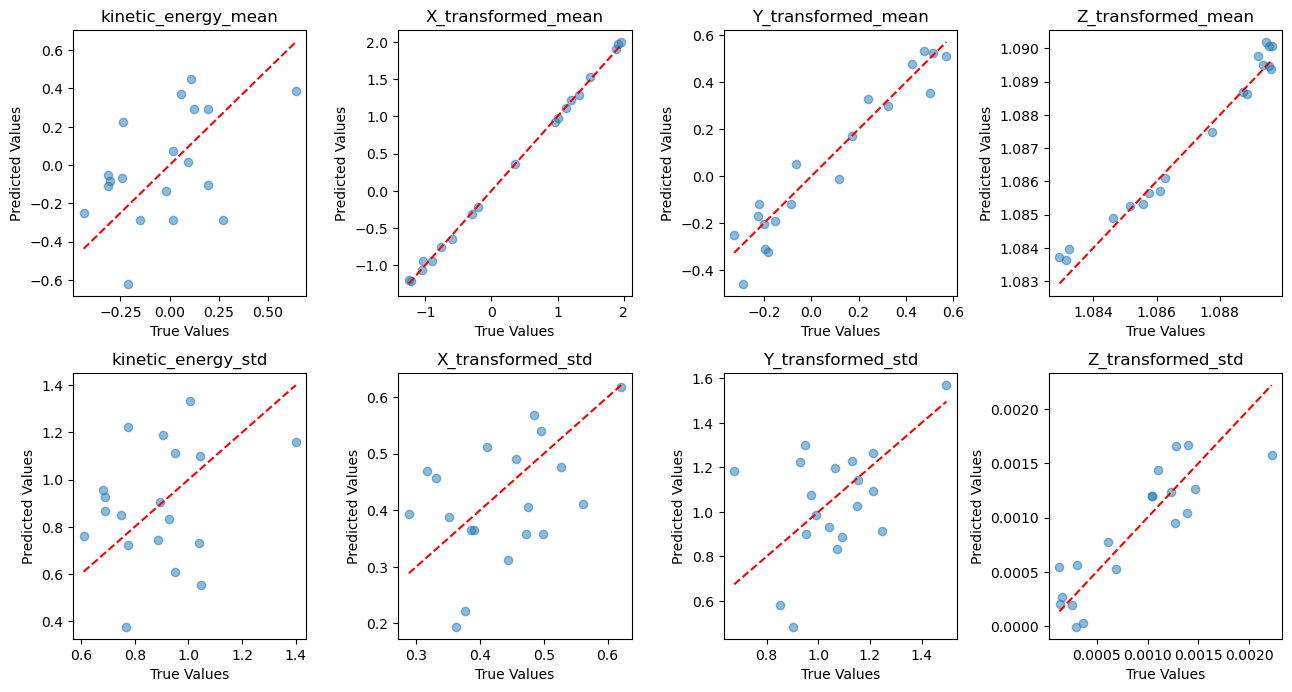

In [20]:
# plot targets vs predictions for validation set
import numpy as np
val_outputs_np = val_outputs.detach().numpy()
val_targets_np = val_targets.detach().numpy()  
plt.figure(figsize=(13, 10))
# use 3 columns per row
for i, col in enumerate(output_columns):
    plt.subplot(len(output_columns)//4+1, 4, i+1)
    plt.scatter(val_targets_np[:, i], val_outputs_np[:, i], alpha=0.5)
    plt.plot([val_targets_np[:, i].min(), val_targets_np[:, i].max()],
             [val_targets_np[:, i].min(), val_targets_np[:, i].max()], 'r--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(col)
plt.tight_layout(pad=1.0)
